# Defect Detection with Image Segmentation

In [1]:
import os
import cv2
import shutil

import glob
import numpy as np
import cv2
import json
import time

import matplotlib.image as mpimg
from IPython.display import Image
%matplotlib inline

!pip install xmltodict
import xmltodict

import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split

In [2]:
!wget https://resources.mpi-inf.mpg.de/conference/dagm/2007/Class1_def.zip
!unzip -q Class1_def.zip -d .

--2020-04-23 08:27:10--  https://resources.mpi-inf.mpg.de/conference/dagm/2007/Class1_def.zip
Resolving resources.mpi-inf.mpg.de (resources.mpi-inf.mpg.de)... 139.19.206.46
Connecting to resources.mpi-inf.mpg.de (resources.mpi-inf.mpg.de)|139.19.206.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34556484 (33M) [application/zip]
Saving to: ‘Class1_def.zip’

Class1_def.zip      100%[===================>]  32.96M  12.9MB/s    in 2.6s    

2020-04-23 08:27:13 (12.9 MB/s) - ‘Class1_def.zip’ saved [34556484/34556484]



In [ ]:
DATA_DIR = '/content/Class1_def'

In [ ]:
def load_coordinates(path_to_coor):
    coord_dict = {}
    coord_dict_all = {}
    with open(path_to_coor) as f:
        coordinates = f.read().split('\n')
        for coord in coordinates:
            # print(len(coord.split('\t')))
            if len(coord.split('\t')) == 6:
                coord_dict = {}
                coord_split = coord.split('\t')
                # print(coord_split)
                # print('\n')
                coord_dict['major_axis'] = round(float(coord_split[1]))
                coord_dict['minor_axis'] = round(float(coord_split[2]))
                coord_dict['angle'] = float(coord_split[3])
                coord_dict['x'] = round(float(coord_split[4]))
                coord_dict['y'] = round(float(coord_split[5]))
                index = int(coord_split[0]) - 1
                coord_dict_all[index] = coord_dict

    return coord_dict_all

def get_mask_seg_ellipse(path_to_img):
    # get the image

    img = mpimg.imread(path_to_img)
    basename = os.path.basename(path_to_img)

    # filename_index, e.g. filename = 1.png
    # filename_index = 1, for extracting coordinates
    filename_index = int(os.path.splitext(basename)[0]) - 1
    # print(filename_index)

    path_to_coordinates = path_to_img.replace(basename, 'labels.txt')
    coordinates = load_coordinates(path_to_coordinates)

    mask = np.zeros_like(img)
    mask = cv2.ellipse(mask, 
                       (int(coordinates[filename_index]['x']), int(coordinates[filename_index]['y'])),
                       (int(coordinates[filename_index]['major_axis']), int(coordinates[filename_index]['minor_axis'])),
                       (coordinates[filename_index]['angle'] / 4.7) * 270,
                       0, 
                       360, 
                       (255, 255, 255), 
                       -1)

    mask[mask > 0] = 1.

    # print(coordinates[filename_index]['angle'])

    return mask

def plot_ellipse_seg_test(path_to_img):

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)

    plt.imshow(mpimg.imread(path_to_img), cmap='gray')
    plt.subplot(1, 2, 2)
    mask = get_mask_seg_ellipse(path_to_img)
    plt.imshow(mask, cmap='gray')

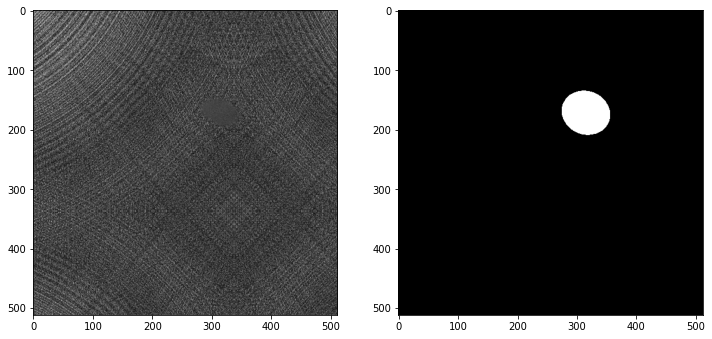

In [5]:
plot_ellipse_seg_test(os.path.join(DATA_DIR, "2.png"))

In [ ]:
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
IMAGE_CHANNELS = 1
IMAGE_SHAPE = (180, 180)
PIXEL_DEPTH = 256

def load_images_masks(path_to_images, img_type, img_format, resize, ellipse=False):

    if not ellipse:
        image_names = [x for x in os.listdir(path_to_images) if x.endswith('.xml')]
    else:
        image_names = [x for x in os.listdir(path_to_images) if x.endswith(img_type)]

    image_num = len(image_names)
    images_all = np.empty([image_num, resize[0], resize[1], IMAGE_CHANNELS])
    labels_all = np.empty([image_num, resize[0], resize[1], IMAGE_CHANNELS])

    if not ellipse:
        image_names = [x.replace('xml', img_type) for x in image_names]

    for image_index in range(image_num):
        image_filename = image_names[image_index]
        # print(image_filename)
        # print(image_filename)
        image = mpimg.imread(os.path.join(path_to_images, image_filename), format=img_format)
        if ellipse:
            mask = get_mask_seg_ellipse(os.path.join(path_to_images, image_filename))
        else:
            mask = get_mask_seg(os.path.join(path_to_images, image_filename))

        if resize:
            image = cv2.resize(image, (resize[0], resize[1]))
            mask = cv2.resize(mask, (resize[0], resize[1]))

        images_all[image_index] = np.reshape(image, (resize[0], resize[1], IMAGE_CHANNELS))
        labels_all[image_index] = np.reshape(mask, (resize[0], resize[1], IMAGE_CHANNELS))

    return images_all, labels_all

In [7]:
X, y = load_images_masks(DATA_DIR, img_type='png', img_format='gray', resize=(512, 512), ellipse=True)
print(X.shape)
print(y.shape)

(150, 512, 512, 1)
(150, 512, 512, 1)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(105, 512, 512, 1)
(45, 512, 512, 1)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from scipy.ndimage.measurements import label
import time

img_rows = 512
img_cols = 512

# Defining a small Unet

def get_small_unet():
    inputs = Input((img_rows, img_cols, 1))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(32, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(16, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(8, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

model = get_small_unet()

In [ ]:
def smooth_dice_coeff(smooth=1.):

    smooth = float(smooth)

    # IOU or dice coeff calculation
    def IOU_calc(y_true, y_pred):
            y_true_f = K.flatten(y_true)
            y_pred_f = K.flatten(y_pred)
            intersection = K.sum(y_true_f * y_pred_f)

            return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def IOU_calc_loss(y_true, y_pred):
        return -IOU_calc(y_true, y_pred)
    return IOU_calc, IOU_calc_loss

IOU_calc, IOU_calc_loss = smooth_dice_coeff(0.00001)

In [ ]:
model.compile(optimizer=Adam(lr=1e-4), loss=IOU_calc_loss, metrics=[IOU_calc])

In [12]:
history = model.fit(X_train, y_train, batch_size=10, epochs=50, verbose=1, validation_split=0.1)

Epoch 1/50
10/10 [==============================] - 3s 315ms/step - loss: -7.0166e-05 - IOU_calc: 7.0166e-05 - val_loss: -5.8381e-04 - val_IOU_calc: 5.8381e-04
Epoch 2/50
10/10 [==============================] - 2s 153ms/step - loss: -0.0064 - IOU_calc: 0.0064 - val_loss: -0.0209 - val_IOU_calc: 0.0209
Epoch 3/50
10/10 [==============================] - 2s 152ms/step - loss: -0.0592 - IOU_calc: 0.0592 - val_loss: -0.0628 - val_IOU_calc: 0.0628
Epoch 4/50
10/10 [==============================] - 2s 153ms/step - loss: -0.0848 - IOU_calc: 0.0848 - val_loss: -0.0700 - val_IOU_calc: 0.0700
Epoch 5/50
10/10 [==============================] - 2s 154ms/step - loss: -0.1028 - IOU_calc: 0.1028 - val_loss: -0.1135 - val_IOU_calc: 0.1135
Epoch 6/50
10/10 [==============================] - 2s 156ms/step - loss: -0.1611 - IOU_calc: 0.1611 - val_loss: -0.2546 - val_IOU_calc: 0.2546
Epoch 7/50
10/10 [==============================] - 2s 152ms/step - loss: -0.2400 - IOU_calc: 0.2400 - val_loss: -0.3197

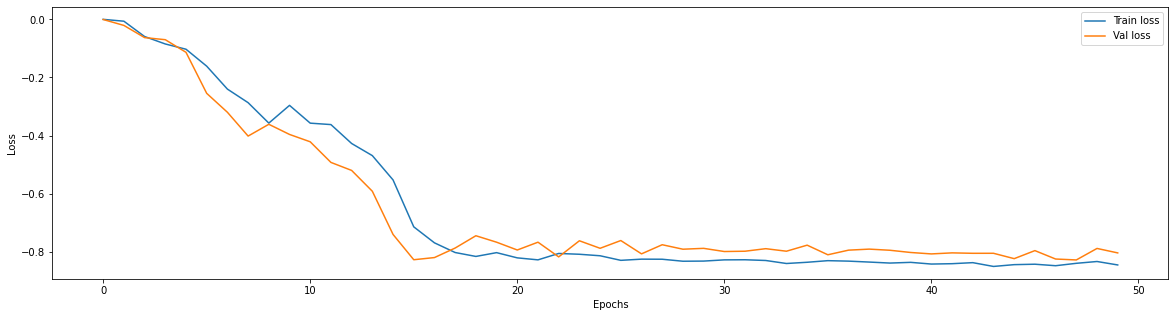

In [13]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Train loss')
plt.plot(model.history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

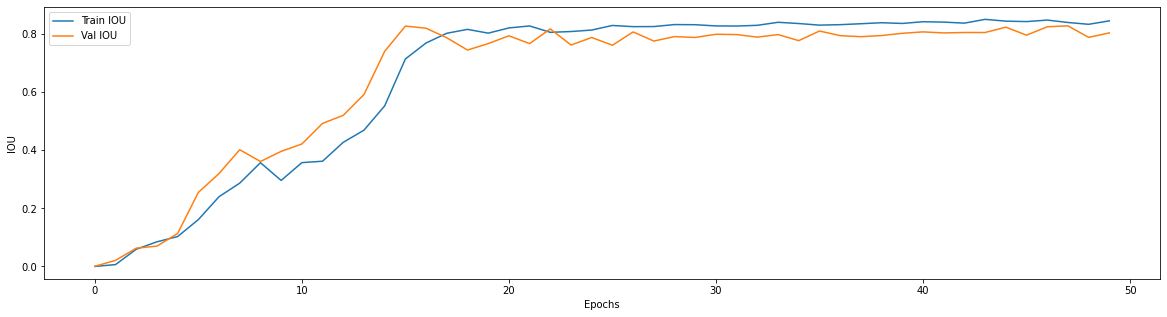

In [14]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['IOU_calc'], label='Train IOU')
plt.plot(model.history.history['val_IOU_calc'], label='Val IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()

In [ ]:
predict = model.predict(X_test)

In [ ]:
def predict_evaluation(pred, image, label):
    # transform gray image to rgb
    img = np.array(image, np.uint8)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # scale pred and mask's pixel range to 0~255
    im_label = np.array(255*label, dtype=np.uint8)
    im_pred = np.array(255*pred, dtype=np.uint8)

    # transform both of them to rgb
    rgb_label = cv2.cvtColor(im_label, cv2.COLOR_GRAY2RGB)
    rgb_pred = cv2.cvtColor(im_pred, cv2.COLOR_GRAY2RGB)

    rgb_label[:, :, 1:3] = 0*rgb_label[:, :, 1:2]
    rgb_pred[:, :, 0] = 0*rgb_pred[:, :, 0]
    rgb_pred[:, :, 2] = 0*rgb_pred[:, :, 2]

    img_pred = cv2.addWeighted(rgb_img, 1, rgb_pred, 0.3, 0)
    img_label = cv2.addWeighted(rgb_img, 1, rgb_label, 0.3, 0)

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_img)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img_pred)
    plt.title('Prediction')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(img_label)
    plt.title('Ground truth')
    plt.axis('off')

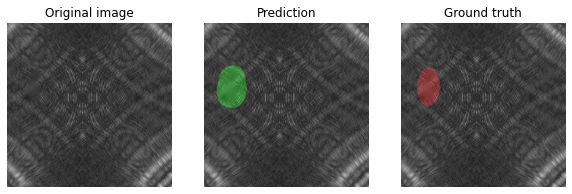

In [17]:
predict_evaluation(predict[0,:,:,0], X_test[0,:,:,0], y_test[0,:,:,0])

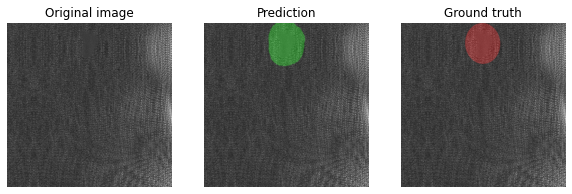

In [18]:
predict_evaluation(predict[1,:,:,0], X_test[1,:,:,0], y_test[1,:,:,0])

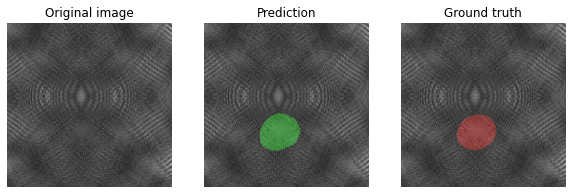

In [19]:
predict_evaluation(predict[2,:,:,0], X_test[2,:,:,0], y_test[2,:,:,0])

### Helper functions

In [ ]:
def get_coordinates(path_to_label, xml):
    with open(path_to_label, encoding='utf-8') as f:
        if xml:
            label_xml = xmltodict.parse(f.read())

            # print(type(label_xml))
            # print(label_xml)

            coordinates_object = label_xml['annotation']['object']
        else:
            label_txt = f.read()
            coordinates_object = label_txt.strip().split('\n')

    return coordinates_object




def get_image(path_to_image):
    return mpimg.imread(path_to_image)


def separate_xml_files(path_to_images):
    file_basenames = [os.path.splitext(x)[0] for x in os.listdir(path_to_images) if x.endswith('xml')]
    image_directory = path_to_images.split('/')[-1]
    new_image_directory = image_directory + '_xml'
    print('image_directory {}'.format(image_directory))
    print('new image directory {}'.format(new_image_directory))
    # directory_newname = os.path.basename(path_to_images) + '_xml'
    # print(directory_newname)
    # os.makedirs(directory_newname)
    for basename in file_basenames:
        # print(basename)
        original_img = os.path.join(path_to_images, basename)
        remove_img = original_img.replace(image_directory, new_image_directory)
        print(remove_img)
        shutil.copy('{}.bmp'.format(original_img), '{}.bmp'.format(remove_img))
        shutil.copy('{}.xml'.format(original_img), '{}.xml'.format(remove_img))

In [ ]:
def xml_to_kitti(path_to_xml):
    # defect_type = os.path.dirname(path_to_xml).split('/')[-1]

    for xml_file in glob.glob('{}/*.xml'.format(path_to_xml)):
        with open(xml_file) as f:
            label_in_xml = xmltodict.parse(f.read())['annotation']['object']

            root_name = os.path.splitext(os.path.basename(xml_file))[0] + '.txt'
            path_to_output = os.path.join(path_to_xml, root_name)
            f_out = open(path_to_output, 'w')

            # print('writing file: {}'.format(root_name))
            if type(label_in_xml) is list:
                # return label_in_xml
                for bbox_object in label_in_xml:
                    bbox = bbox_object['bndbox']
                    defect_type = bbox_object['name']
                    f_out.write('{} 0 0 0 {} {} {} {} 0 0 0 0 0 0 0'.format(defect_type,
                                                                            bbox['xmin'],
                                                                            bbox['ymin'],
                                                                            bbox['xmax'],
                                                                            bbox['ymax']))
                    f_out.write('\n')
            else:
                bbox = label_in_xml['bndbox']
                defect_type = label_in_xml['name']
                f_out.write('{} 0 0 0 {} {} {} {} 0 0 0 0 0 0 0'.format(defect_type,
                                                                        bbox['xmin'],
                                                                        bbox['ymin'],
                                                                        bbox['xmax'],
                                                                        bbox['ymax']))
            f_out.close()


def get_mask_seg(path_to_img, xml=True):
    '''create image for segmentation application

    Arg:
        img (numpy array): original grayscale or color rgb image
        coord_min (tuple): (xmin, ymin)
        coord_max (tuple): (xmax, ymax)

    Return:

    Notes:
    '''

    img = mpimg.imread(path_to_img)

    img_mask = np.zeros_like(img[:, :])

    if xml:
        path_to_xml = path_to_img.replace('bmp', 'xml')
        # print('path_to_xml: {}'.format(path_to_xml))
        coor_obj = get_coordinates(path_to_xml, xml)

        # if there are more than 1 bounding boxes
        if type(coor_obj) is list:
            for i in range(len(coor_obj)):
                xmin = int(coor_obj[i]['bndbox']['xmin'])
                ymin = int(coor_obj[i]['bndbox']['ymin'])
                xmax = int(coor_obj[i]['bndbox']['xmax'])
                ymax = int(coor_obj[i]['bndbox']['ymax'])

                img_mask[ymin:ymax, xmin:xmax] = 1.
        else:
            # there is only one bounding box
            # print('test')
            xmin = int(coor_obj['bndbox']['xmin'])
            ymin = int(coor_obj['bndbox']['ymin'])
            xmax = int(coor_obj['bndbox']['xmax'])
            ymax = int(coor_obj['bndbox']['ymax'])

            img_mask[ymin:ymax, xmin:xmax] = 1.

    return img_mask




def get_mask_seg_polygon(path_to_img, gray=True):
    img = mpimg.imread(path_to_img)
    
    if not gray:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    basename = os.path.basename(path_to_img)
    
    path_to_json = path_to_img.replace('bmp', 'json')
    
    # print(path_to_json)
    
    with open(path_to_json) as json_file:
        json_get = json.load(json_file)
        pts_list = [np.array(pts['points'], np.int32) for pts in json_get['shapes']]
    
    
    # return np.array(pts, np.int32)
    
    mask = np.zeros_like(img)
    
    # rgb_pred = cv2.cvtColor(im_pred, cv2.COLOR_GRAY2RGB)
    # return mask
    mask = cv2.fillPoly(mask, pts_list, (255, 255, 255))
    
    mask[mask > 0] = 1.
    
    return mask

In [ ]:
def plot_ellipse(raw_img, coordinates):
    """plot image with ellipse contour


    """

    img_copy = raw_img.copy()

    # return img_copy

    return_img = cv2.ellipse(img_copy,
                             (coordinates['x'], coordinates['y']),
                             (coordinates['major_axis'], coordinates['minor_axis']),
                             coordinates['angle'] * 90,
                             # -90,
                             0,
                             360,
                             (0, 0, 0),
                             2)

    plt.imshow(return_img, cmap='gray')
    print('angle: {}'.format(coordinates['angle']))
    print('angle(degree): {}'.format(90 * coordinates['angle']))


    return return_img



def plot_bbox(path_to_image, xml):
    '''plot bbox on raw image

    Args:
        raw_img (numpy array):
        coordinates (dict):

    Return:

    '''
    img = mpimg.imread(path_to_image)

    if xml:
        path_to_label = path_to_image.replace('.bmp', '.xml')
        # print(path_to_label)
        coordinates_object = get_coordinates(path_to_label, xml=True)
    else:
        path_to_label = path_to_image.replace('.bmp', '.txt')
        # print(path_to_label)
        coordinates_object = get_coordinates(path_to_label, xml=False)
        # return coordinates_object
    # return coordinates_object

    img_copy = img.copy()
    if type(coordinates_object) is list:
        print('{} bounding boxes'.format(len(coordinates_object)))
        for i in range(len(coordinates_object)):
            if xml:
                coordinates = coordinates_object[i]['bndbox']

                print('Defect type: {}'.format(coordinates_object[i]['name']))
                print('xmin: {} ymin: {} xmax: {} ymax:{}'.format(int(coordinates['xmin']),
                                                                                                        int(coordinates['ymin']),
                                                                                                        int(coordinates['xmax']),
                                                                                                        int(coordinates['ymax'])))

                return_img = cv2.rectangle(img_copy, (int(coordinates['xmin']), int(coordinates['ymin'])),
                                                                             (int(coordinates['xmax']), int(coordinates['ymax'])),
                                                                             (255, 0, 0),5)


            else:
                # return coordinates_object
                # print(coordinates_object)
                print('Defect type: {}'.format(coordinates_object[i].split()[0]))
                print('xmin: {} ymin: {} xmax: {} ymax:{}'.format(int(coordinates_object[i].split()[4]),
                                                                                                        int(coordinates_object[i].split()[5]),
                                                                                                        int(coordinates_object[i].split()[6]),
                                                                                                        int(coordinates_object[i].split()[7])))

                return_img = cv2.rectangle(img_copy, (int(coordinates_object[i].split()[4]),
                                                                             int(coordinates_object[i].split()[5])),
                                                                             (int(coordinates_object[i].split()[6]),
                                                                             int(coordinates_object[i].split()[7])),
                                                                             (255, 0, 0), 5)
    else:
        coordinates = coordinates_object['bndbox']
        print('1 bounding box')
        print('Defect type: {}'.format(coordinates_object['name']))
        print('xmin: {} ymin: {} xmax: {} ymax:{}'.format(int(coordinates['xmin']),
                                                          int(coordinates['ymin']),
                                                          int(coordinates['xmax']),
                                                          int(coordinates['ymax'])))
        return_img = cv2.rectangle(img_copy, (int(coordinates['xmin']), int(coordinates['ymin'])),
                                                                         (int(coordinates['xmax']), int(coordinates['ymax'])),
                                                                         (255, 0, 0),5)
    plt.imshow(return_img, cmap='gray')

    return return_img


def plot_bbox_seg_test(path_to_img, xml=True):
    """plot bbox and seg

    Args:
      path_to_img (str): path to image
      xml (boolean): specified label data, xml or txt

    Return: None

    Notes:
    """
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    test = plot_bbox(path_to_img, xml=True)
    plt.subplot(1, 2, 2)
    img_mask = get_mask_seg(path_to_img, xml=True)
    plt.imshow(img_mask, cmap='gray')
    
def plot_polygon_seg_test(path_to_img, gray=True):

    plt.figure(figsize=(30, 20))
    plt.subplot(1, 3, 1)
    
    raw_img = mpimg.imread(path_to_img)
    if gray:
        raw_img = cv2.cvtColor(raw_img, cv2.COLOR_GRAY2RGB)
    plt.imshow(raw_img)
    plt.subplot(1, 3, 2)
    mask = get_mask_seg_polygon(path_to_img)
    im_mask = np.array(255*mask, dtype=np.uint8)
    rgb_mask = cv2.cvtColor(im_mask, cv2.COLOR_GRAY2RGB)
    rgb_mask[:,:,1:3] = 0*rgb_mask[:,:,1:2]
    
    plt.imshow(mask, cmap='gray')
    
    img_mask = cv2.addWeighted(raw_img, 1, rgb_mask, 0.8, 0)
    
    plt.subplot(1, 3, 3)
    plt.imshow(img_mask)

In [ ]:
def load_images(path_to_images, shape=(256, 256), filename_index=True):

    # get image paths
    image_files = [x for x in os.listdir(path_to_images) if (os.path.splitext(x)[1] == '.bmp') or
                                                            (os.path.splitext(x)[1] == '.png')]
    dataset = np.ndarray(shape=(len(image_files),
                                shape[0],
                                shape[1]),
                         dtype=np.float32)

    # fill in images into numpy array (tensor)
    file_ext = os.path.splitext(image_files[0])[1]

    # print(file_ext)
    for index, image_path in enumerate(glob.glob(path_to_images + '*{}'.format(file_ext))):
        # print(image_path)
        rgb_image = cv2.imread(image_path)
        # print(rgb_image.shape)
        gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
        image_data = (gray_image.astype(float) - PIXEL_DEPTH) / PIXEL_DEPTH

        if not filename_index:
            dataset[index, :, :] = image_data
        else:
            file_index = int(os.path.splitext(os.path.basename(image_path))[0]) - 1
            # print(file_index)
            dataset[file_index, :, :] = image_data
            # print(file_index)
    return dataset


def batch_generator(path_to_images, batch_size, is_training, augment, resize):
    """Genetate training/testing image

    Args:
        path_to_image (string):
        batch_size (int):
        is_training (boolean):
        augment (boolean):

    Return:
        yield batch imagese
    """

    # image_num = len([x for x in os.listdir(path_to_images) if x.endswith('bmp')])
    image_names = [x for x in os.listdir(path_to_images) if x.endswith('bmp')]
    image_num = len(image_names)
    batch_images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    batch_masks = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])

    while True:
        i = 0
        for image_index in np.random.permutation(image_num):
            if is_training:
                if augment:
                    image = augment(path_to_images, image_names[image_index])
                else:
                    image = mpimg.imread(os.path.join(path_to_images, image_names[image_index]))

                mask = get_mask_seg(os.path.join(path_to_images, image_names[image_index]), xml=True)
                if resize:
                    image = cv2.resize(image, (resize[0], resize[1]))
                    mask = cv2.resize(mask, (resize[0], resize[1]))
                batch_images[i] = np.reshape(image, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
                batch_masks[i] = np.reshape(mask, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
            else:
                image = mpimg.imread(os.path.join(path_to_images, image_names[image_index]))
                mask = get_mask_seg(os.path.join(path_to_images, image_names[image_index]), xml=True)
                if resize:
                    image = cv2.resize(image, (resize[0], resize[1]))
                    mask = cv2.resize(mask, (resize[0], resize[1]))
                batch_images[i] = np.reshape(image, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
                batch_masks[i] = np.reshape(mask, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
            i += 1
            if i == batch_size:
                break

        yield batch_images, batch_masks


def load_test_images(path_to_images, img_type, img_format, resize, ellipse=False):
    image_names = [x for x in os.listdir(path_to_images) if x.endswith(img_type)]
    image_num = len(image_names)
    images_all = np.empty([image_num, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    # labels_all = np.empty([image_num, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])

    for image_index in range(image_num):
        image_filename = image_names[image_index]
        # print(image_filename)
        image = mpimg.imread(os.path.join(path_to_images, image_filename), format=img_format)
        # mask = get_mask_seg_ellipse(os.path.join(path_to_images, image_filename))

        if resize:
            image = cv2.resize(image, (resize[0], resize[1]))

        images_all[image_index] = np.reshape(image, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
        #labels_all[image_index] = np.reshape(mask, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

    return images_all


def load_ok_images(path_to_images, img_type, img_format, resize, ellipse=False):
    image_names = [x for x in os.listdir(path_to_images) if not x.endswith('xml')]

    image_num = len(image_names)
    images_all = np.empty([image_num, resize[0], resize[1], IMAGE_CHANNELS])
    # labels_all = np.empty([image_num, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    # images_names = [x.replace('xml', 'bmp')]

    for image_index in range(image_num):

        image_filename = image_names[image_index]
        # print(image_filename)
        image = mpimg.imread(os.path.join(path_to_images, image_filename), format=img_format)
        # mask = get_mask_seg_ellipse(os.path.join(path_to_images, image_filename))

        if resize:
            image = cv2.resize(image, (resize[0], resize[1]))
        # print(image.shape)
        images_all[image_index] = np.reshape(image, (resize[0], resize[1], IMAGE_CHANNELS))
        #labels_all[image_index] = np.reshape(mask, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

    return images_all, image_names


In [ ]:
def load_data(args):
    '''
    '''
    defect_imgs = load_images(args)

    X_train, X_valid = train_test_split()

    return X_train, X_valid


def build_model():
    '''
    '''
    with tf.name_scope('encoder'):
        x = Convolution2D(128, (1, 1), activation='elu', padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Convolution2D(96, (3, 3), activation='elu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Convolution2D(80, (3, 3), activation='elu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Convolution2D(64, (1, 1), activation='elu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Convolution2D(48, (3, 3), activation='elu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Convolution2D(36, (3, 3), activation='elu', padding='same')(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)
    with tf.name_scope('decoder'):
        x = Convolution2D(36, (3, 3), activation='elu', padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Convolution2D(48, (3, 3), activation='elu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Convolution2D(64, (1, 1), activation='elu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Convolution2D(80, (3, 3), activation='elu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Convolution2D(96, (3, 3), activation='elu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Convolution2D(128, (1, 1), activation='elu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Convolution2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='nadam', loss='mean_squared_error')

    return model


def build_small_unet(img_rows, img_cols):
    """build u-net model

    Args:
        img_rows (int):
        img_cols (int):

    Return:

    Notes:
    """
    inputs = Input((img_rows, img_cols, 1))
    inputs_norm = Lambda(lambda x: x / 127.5 - 1.)
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4)], mode = 'concat', concat_axis = 3)
    conv6=Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(up6)
    conv6=Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv6)

    up7=merge([UpSampling2D(size=(2, 2)(conv6)), conv3], mode = 'concat', concat_axis = 3)
    conv7=Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(up7)
    conv7=Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv7)

    up8=merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode = 'concat', concat_axis = 3)
    conv8=Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(up8)
    conv8=Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(conv8)

    up9=merge([UpSampling2D(size=(2, 2))(conv8), conv1], model = 'concat', concat_axis = 3)
    conv9=Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(up9)
    conv9=Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(conv9)

    conv10=Conv2D(1, (1, 1), activation = 'sigmoid')(conv9)

    model=Model(inputs = inputs, outputs = conv10)

    return model

def train_model(model, args, X_train, X_valid):

    # set up the checkpoint for the model
    checkpoint=ModelCheckpoint('model-{epoch:03d}.h5',
                                 monitor = 'val_loss',
                                 verbose = 0,
                                 save_best_only = args.save_best_only,
                                 mode = 'auto')

    # compoile the model
    model.compile(loss = 'mean_squared_error', optimizer = Adam(lr=args.learning_rate)
    # fitting the model
    model.fit(np.reshape(X_train (len(X_train), X_train.shape[0]), X_train.shpae[1]),
              batch_size=args.samples_per_epoch,
              )


    return model

def main():
    """
    Load training data and training the model
    """

    ap = argparse.ArgumentParser('Cosmetics Inspection with AutoEncoder')
    ap.add_argument()


In [ ]:
def convert_keras_to_pb(path_to_kmodel, out_node):
    """convert keras model (json with hdf5 format) to tensorflow pb format (protobuf format)
    
    Arguments:
        path_to_kmodel (string): path to keras model files, model structure in json format, model weights in hdf5 format 
    
    Return:
        
    
    Notes:
    
    """
    # get model in json and hdf5 format (from tensorflow.keras export)
    model_json = [file for file in os.listdir(path_to_kmodel) if file.endswith('json')][0]
    # print(model_json)
    model_weights = [file for file in os.listdir(path_to_kmodel) if file.endswith('h5')][0]
    # print(model_weights)
    # load the model structure (json file)
    with open(os.path.join(path_to_kmodel, model_json)) as f:
        model_json_string = f.read()
    model = model_from_json(model_json_string)
    
    # load model weights in hdf5 format (from tensorflow.keras export)
    model.load_weights(os.path.join(path_to_kmodel, model_weights))
        
        
    # All new operations will be in test mode from now on
    K.set_learning_phase(0)
    
    checkpoint_prefix = os.path.join(path_to_kmodel, "saved_checkpoint")
    checkpoint_state_name = "checkpoint_state"
    input_graph_name = 'input_graph.pb'
    output_graph_name = 'output_graph.pb'
    
    # Temporary save graph to disk without weights included.
    saver = tf.train.Saver()
    #saver = saver_lib.Saver(write_version=saver_pb2.SaverDef.V2)
    
    checkpoint_path = saver.save(sess=K.get_session(), 
                                 save_path=checkpoint_prefix, 
                                 global_step=0, 
                                 latest_filename=checkpoint_state_name)
    
    # 
    tf.train.write_graph(graph_or_graph_def=K.get_session().graph,
                         logdir=path_to_kmodel,
                         name=input_graph_name)
    
    
    # Embed weights inside the graph and save to disk
    freeze_graph.freeze_graph(input_graph=os.path.join(path_to_kmodel, input_graph_name),
                              input_saver="",
                              input_binary=False,
                              input_checkpoint=checkpoint_path,
                              output_node_names=out_node,
                              restore_op_name='save/restore_all',
                              filename_tensor_name='save/Const:0',
                              output_graph=os.path.join(path_to_kmodel, output_graph_name),
                              clear_devices=False,
                              initializer_nodes=''
                              )
    
    return model



def print_output_node_names(path_to_kmodel):
    """get last few output node names
    
    
    """
    model_json = [file for file in os.listdir(path_to_kmodel) if file.endswith('json')][0]
    model_weights = [file for file in os.listdir(path_to_kmodel) if file.endswith('h5')][0]
    
    with open(os.path.join(path_to_kmodel, model_json)) as f:
        model_json_string = f.read()
        
    model = model_from_json(model_json_string)
    model.load_weights(os.path.join(path_to_kmodel, model_weights))
    K.set_learning_phase(0)
    for i in range(3):
        layer = model.layers[-(i+1)]
        print(layer.name)
        print(layer.output)
        # print('11')
        print(layer.output.op.name)

In [ ]:
flags = tf.app.flags
FLAGS = flags.FLAGS
# define parameters
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate')
flags.DEFINE_string('path_to_data', 'data/', 'Path to the training and validation dataset')

run_training()
tf.app.run()